<font size="+3"><strong>NVDA Volatility Forecasting</strong></font>

In this project we'll build a model to predict stock volatility for the tech company NVIDIA Corp.

In [1]:
# pip install relevant python library
!pip install arch pydantic FastAPI

In [2]:
# Import libraries
%load_ext autoreload
%autoreload 2

from arch.univariate.base import ARCHModelResult
import os
import sqlite3
from glob import glob

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

from arch import arch_model
from arch.univariate.base import ARCHModelResult
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from config import settings
from data import SQLRepository


# Working with AlphaVantage API

Create a URL to get all the stock data for NVIDIA Corp (`"NVDA"`) from AlphaVantage in JSON format.

Components of the URL below and their meaning;

| URL | Component |
|:--- | :-------- |
| `https://www.alphavantage.co` | It is the **hostname** or web address for the server where we get our stock data. |
| `/query` | The **path**- the name of the particular operation we want to access. |
| `?` |  It denotes that everything that follows in the URL is a **parameter**. Each parameter is separated by a `&` character. Parameters provide additional information that will change the operation's behavior- similar to **arguments** in Python functions. |
| `function=TIME_SERIES_DAILY` | The first parameter uses the `function` keyword with a `TIME_SERIES_DAILY` i.e. we're querying **daily** stock data. |
| `symbol=NVDA` | The next parameter is the `symbol` keyword- we're querying for data on a stock whose [**ticker symbol**] is `NVDA`. |
| `apikey=api_key` | an **API key** or **API token** is the password used to access the API. |

In [3]:
ticker = "NVDA"
output_size = "full"
data_type = "json"

url = (
    "https://www.alphavantage.co/query?"
    "function=TIME_SERIES_DAILY&"
    f"symbol={ticker}&"
    f"outputsize={output_size}&"
    f"datatype={data_type}&"
    f"apikey={settings.alpha_api_key}"
)

print("url type:", type(url))
url

url type: <class 'str'>


'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=NVDA&outputsize=full&datatype=json&apikey=39DTA561IBS8FQMZ'

Create an HTTP request for the URL created above.

**NOTE:** This is done to get the required data from the `url`

In [4]:
response = requests.get(url)

print("response type:", type(response))

response type: <class 'requests.models.Response'>


Get status code of the response and assign it to the variable response_code.

**NOTE:** A status code of `200` means the request was successful.

In [5]:
response_code = response.status_code

print("code type:", type(response_code))
response_code

code type: <class 'int'>


200

# Test-Driven Development

- **Create a DataFrame df_nvda with all the stock data for NVIDIA Corp.**

In [6]:
response_data = response.json()
stock_data = response_data['Time Series (Daily)']
df_nvda = pd.DataFrame.from_dict(stock_data, orient='index', dtype=float)

# Convert index to `DatetimeIndex` named "date"
df_nvda.index = pd.to_datetime(df_nvda.index)
df_nvda.index.name = "date"

# Remove numbering from columns
df_nvda.columns = [col_nom.split(". ")[1] for col_nom in df_nvda.columns]

print("df_nvda type:", type(df_nvda))
df_nvda.head()

df_nvda type: <class 'pandas.core.frame.DataFrame'>


,open,high,low,close,volume
date,,,,,
2024-09-04,105.410,113.27,104.12,106.21,368378810.0
2024-09-03,116.010,116.21,107.29,108.00,477155100.0
2024-08-30,119.530,121.75,117.22,119.37,333751583.0
2024-08-29,121.355,124.43,116.71,117.59,453023305.0
2024-08-28,128.120,128.33,122.64,125.61,448101115.0


From the first 5 rows of the dataframe, we notice that the data covers from August 28, 2024, to September 4, 2024.

**Columns:**
- `open`: Opening price of the stock on a given day.
- `high`: Highest price reached during the day.
- `low`: Lowest price reached during the day.
- `close`: Closing price of the stock on a given day.
- `volume`: Number of shares traded.

- **Connect to the database stored in the `".env"` file.**

**NOTE:** Set the `"check_same_thread"` argument to False. **This allows the SQLite connection to be shared across threads, enabling multiple users to access the database simultaneously.**

In [7]:
connection = sqlite3.connect(settings.db_name, check_same_thread=False)
connection

- **Insert df_nvda into the database.**

We first of all instantiate our `SQLRepository` and pass in as argument the `connection` created above.

Finally, we insert the `df_nvda` data into the database.

In [ ]:
# Insert `NVDA` data into database
repo = SQLRepository(connection=connection)

repo.insert_table("NVDA", df_nvda, if_exists="fail")

- **Read the NVDA table from the database and assign the output to df_nvda_read.**

We set the `limit` argument to `None` so all of the data can be read into the dataframe.

In [ ]:
df_nvda_read = repo.read_table("NVDA", limit=None)

print("df_nvda_read type:", type(df_nvda_read))
print("df_nvda_read shape:", df_nvda_read.shape)
df_nvda_read.head()

df_nvda_read type: <class 'pandas.core.frame.DataFrame'>
df_nvda_read shape: (6250, 5)


,open,high,low,close,volume
date,,,,,
2024-09-04,105.410,113.27,104.12,106.21,368378810.0
2024-09-03,116.010,116.21,107.29,108.00,477155100.0
2024-08-30,119.530,121.75,117.22,119.37,333751583.0
2024-08-29,121.355,124.43,116.71,117.59,453023305.0
2024-08-28,128.120,128.33,122.64,125.61,448101115.0


# Predicting Volatility

## Prepare Data

- **Create a Series `"y_nvda"` with the 6,000 most recent returns for NVIDIA Corp.**

In [9]:
# Get table from database
df = repo.read_table(table_name=ticker, limit=6000+1)

# Sort DataFrame ascending by date
df.sort_index(ascending=True, inplace=True)

# Create "return" column
df["return"] = df["close"].pct_change() * 100
y_nvda = df["return"].dropna()

print("y_nvda type:", type(y_nvda))
print("y_nvda shape:", y_nvda.shape)
y_nvda.head()

y_nvda type: <class 'pandas.core.series.Series'>
y_nvda shape: (6000,)


date
2000-10-26    4.257442
2000-10-27   -2.297017
2000-10-30   -7.036735
2000-10-31    9.132420
2000-11-01   -0.016093
Name: return, dtype: float64

**In the above code, we retrieve data from the database table, with limit set to 6001 rows. We then sort the DataFrame by date in ascending order to ensure chronological accuracy. We create a new column (`return`), by calculating the percentage change in the close prices between consecutive days and multiplying it by 100 to express it as a percentage.**

**NOTE:** The percentage change (`pct_change()`) compares the current value with the previous one. For the first row, there is no previous value to compare to, so it results in a NaN value for the first entry in the new return column.

**Finally, the `dropna()` method is then used to remove any missing values, leaving the final series (y_nvda) with 6000 rows.**

- **Calculate daily volatility for `"y_nvda"`, and assign the result to `"nvda_daily_volatility"`.**

**NOTE:** *For time series data like stock returns, standard deviation is commonly used as a measure of volatility.*

*- Volatility refers to the degree of variation in stock returns over time. It captures how much the stock price moves up or down from its average value on a daily basis.*

*- Standard deviation provides a numerical value for this variation, with higher values indicating greater price swings (more volatile) and lower values suggesting more stability (less volatile).*

In [10]:
nvda_daily_volatility =  y_nvda.std()

print("nvda_daily_volatility type:", type(nvda_daily_volatility))
print("NVIDIA Daily Volatility:", nvda_daily_volatility)

nvda_daily_volatility type: <class 'float'>
NVIDIA Daily Volatility: 4.011406904173708


- **Calculate the annual volatility for `"y_nvda"`, and assign the result to `"nvda_annual_volatility"`.**

*We need to calculate the annual volatility, which gives an estimate of how much the stock's price might fluctuate over the course of a year, based on daily fluctuations. Multiplying by np.sqrt(252) scales the daily volatility to reflect yearly movement.*

**NOTE:** A stock trading year is approximately 252 days because stocks are not traded on weekends.

In [11]:
nvda_annual_volatility = nvda_daily_volatility * np.sqrt(252)

print("nvda_annual_volatility type:", type(nvda_annual_volatility))
print("NVIDIA Annual Volatility:", nvda_annual_volatility)

nvda_annual_volatility type: <class 'numpy.float64'>
NVIDIA Annual Volatility: 63.67911045558684


Create a time series line plot for `"y_nvda"` with proper labels and title.

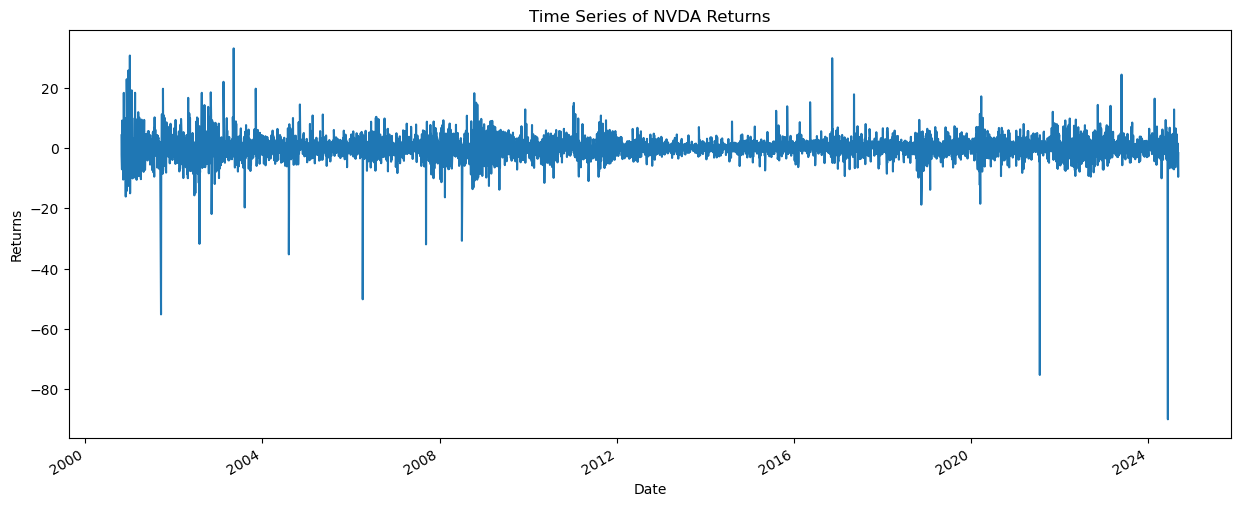

In [ ]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_mtnoy` on `ax`
y_nvda.plot(ax=ax, label="NVDA")

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Returns")

# Add title
plt.title("Time Series of NVDA Returns");

The above plot shows the historical returns of NVIDIA Corporation (NVDA) stock from 2000 to 2024.

Key Observations

- Volatility: The time series exhibits significant volatility, characterized by periods of rapid price fluctuations.

- Clustering: The returns seem to cluster in certain periods, suggesting that periods of high volatility or low volatility tend to persist for a time.

Create an ACF plot of the squared returns for NVIDIA with appropriate labels and title.

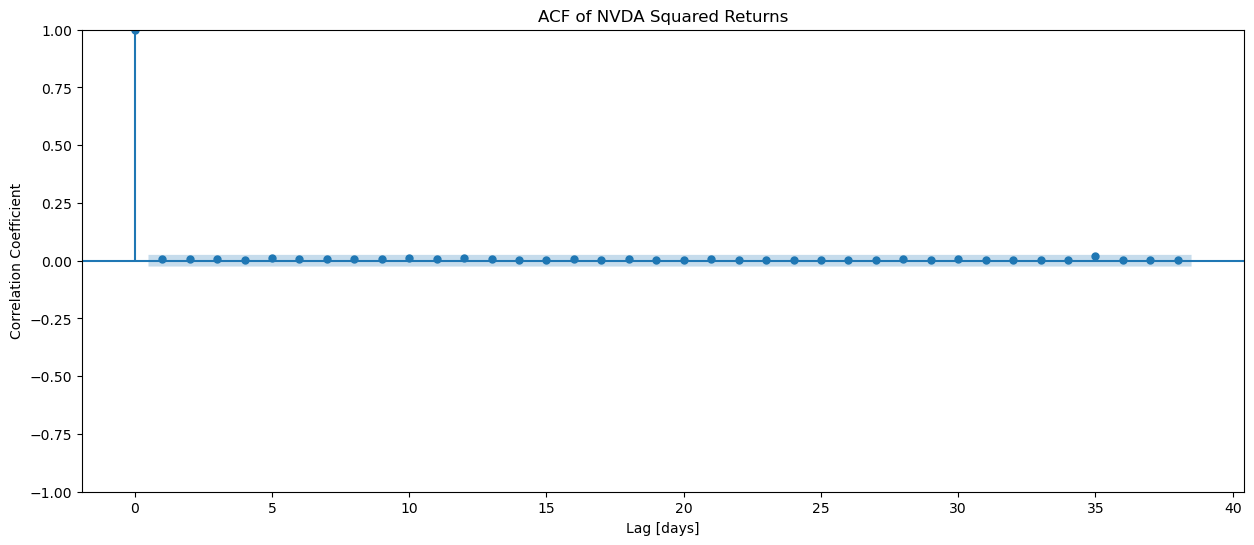

In [ ]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_nvda**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

# Add title
plt.title("ACF of NVDA Squared Returns");

The visualisation is a plot of the AutoCorrelation Function `ACF`.
The ACF measures the correlation between the squared returns at different lags, providing insights into the persistence of volatility.

Key Observations

- Significant Positive Autocorrelation: The ACF shows a significant positive correlation at lag 1, 

- Decaying Autocorrelation: As the lag increases, the autocorrelation coefficients gradually decay towards zero. This indicates that the persistence of volatility is relatively short-lived.

- No Clear Pattern: There is no clear pattern or significant spikes in the ACF beyond lag 1. This suggests that the squared returns are not strongly correlated with past squared returns at lags greater than 1.

- **Create a PACF plot of the squared returns for NVIDIA with appropriate labels and title.**

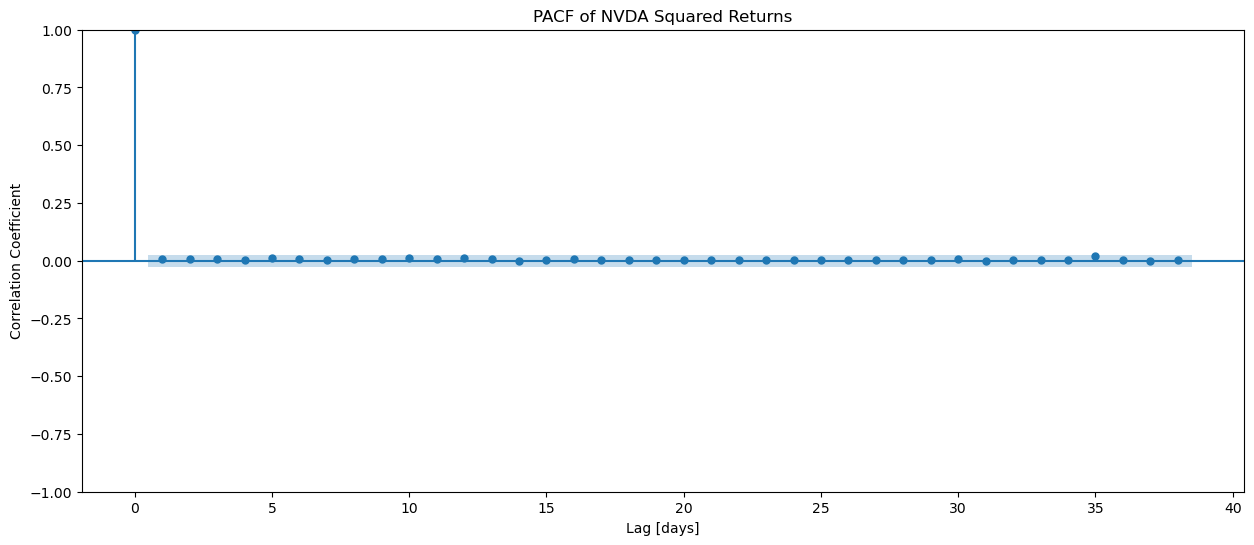

In [ ]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y_nvda**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

# Add title
plt.title("PACF of NVDA Squared Returns");

The PACF measures the correlation between the squared returns at a specific lag, controlling for the effects of intervening lags.

Key Observations

- Significant Positive Partial Autocorrelation at Lag 1: Similar to the ACF, the PACF shows a significant positive partial autocorrelation at lag 1.

- No Significant Partial Autocorrelation at Higher Lags: The PACF coefficients for higher lags are not significantly different from zero. This suggests that the direct relationship between the squared returns at a given lag and the squared returns at time t is primarily explained by the relationship at lag 1.

- **Create a training set `"y_nvda_train"` that contains the first 80% of the observations in `"y_nvda"`.**

**NOTE:** Splitting a time series dataset should be done in chronological order.

In [12]:
cutoff_test = int(len(y_nvda) * 0.8)
y_nvda_train = y_nvda.iloc[: cutoff_test]

print("y_nvda_train type:", type(y_nvda_train))
print("y_nvda_train shape:", y_nvda_train.shape)
y_nvda_train.head()

y_nvda_train type: <class 'pandas.core.series.Series'>
y_nvda_train shape: (4800,)


date
2000-10-26    4.257442
2000-10-27   -2.297017
2000-10-30   -7.036735
2000-10-31    9.132420
2000-11-01   -0.016093
Name: return, dtype: float64

## Build Model

- **Build and fit a GARCH model using the data in `"y_nvda"`. Try different values for `p and q`, using the summary to assess its performance.**

**What is a GARCH Model?**

*A GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model is a statistical model used to estimate the volatility of financial time series data, such as stock returns. It is particularly useful when volatility is not constant over time but exhibits periods of high and low volatility, known as volatility clustering.*

*The GARCH model helps predict future volatility by using past returns and past volatility information.*

Components:

- AR (Autoregressive) component (p): Models how past values of the variable (e.g., stock returns) influence the current value.

- MA (Moving Average) component (q): Models how past residuals (differences between actual and predicted values) affect the current volatility.

`p=1`: This specifies the lag order for the autoregressive (AR) term, meaning the model considers the volatility from one previous time period.

`q=1`: This sets the lag order for the moving average (MA) term, meaning the model takes into account the residuals (errors) from one previous time period.

In [13]:
# Build and train model
model = arch_model(
    y_nvda_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)

print("model type:", type(model))

# Show model summary
print(model.summary())

model type: <class 'arch.univariate.base.ARCHModelResult'>
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12652.1
Distribution:                  Normal   AIC:                           25312.2
Method:            Maximum Likelihood   BIC:                           25338.1
                                        No. Observations:                 4800
Date:                Thu, Sep 05 2024   Df Residuals:                     4799
Time:                        16:49:59   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu

The important aspect from our model summary is the `p-value` of `omega, alpha, beta`.

Both `alpha[1]` and `omega` are not significant (`p-value` > 0.05), suggesting that past shocks and the constant variance term do not play a major role in explaining volatility in this model.
This GARCH(1,1) model highlights that volatility is mostly driven by its own persistence rather than past return shocks.

- **Plot the standardized residuals for the model with appropriate labels and title.**

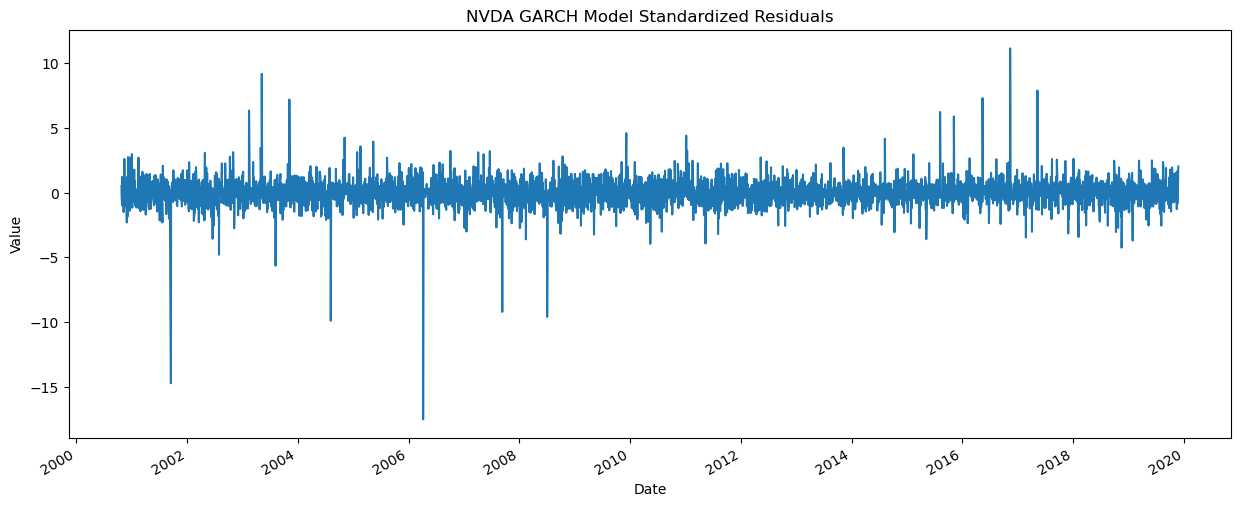

In [14]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label="Standardized Residuals")

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Value")

# Add title
plt.title("NVDA GARCH Model Standardized Residuals");

*The standardized residuals from the NVDA GARCH model appear to be randomly scattered around zero, suggesting that the model is effectively capturing the volatility dynamics of the data. There is no obvious pattern or autocorrelation visible in the residuals, indicating that the GARCH model is capturing the dependence structure in the data. Overall, the visual inspection of the residuals suggests that the GARCH model is a reasonable fit for the NVDA data.*

- **Create an ACF plot of the squared, standardized residuals of the model with appropriate labels and title.**

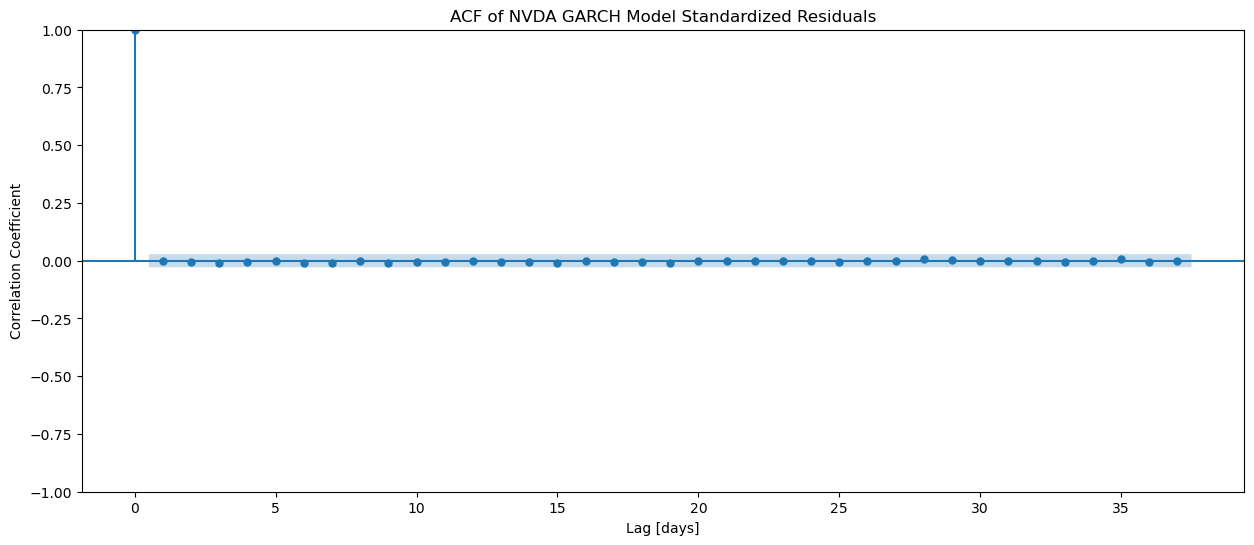

In [ ]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")


# Add title
plt.title("ACF of NVDA GARCH Model Standardized Residuals");

*The ACF of the squared standardized residuals from the NVDA GARCH model shows no significant autocorrelation at any lag. This suggests that the GARCH model is effectively capturing the dependence structure in the data and that the residuals are uncorrelated. The random nature of the ACF coefficients further reinforces the conclusion that the residuals are white noise, indicating that the model is adequately capturing the volatility dynamics. These findings provide strong evidence for the adequacy of the GARCH model in capturing the volatility of NVDA's returns.*

# Model Deployment

Create a `post` request to hit the `"/fit"` path running at `"http://localhost:8008"`. Train a `GARCH(1,1) model on 6000 observations of the NVIDIA Corp data already downloaded.

In [ ]:
# URL of `/fit` path
url = "http://localhost:8008/fit"

# Data to send to path
json = {
    "ticker": "NVDA",
    "use_new_data": False,
    "n_observations": 6000,
    "p": 1,
    "q": 1
}
# Response of post request
response = requests.post(url=url, json=json)

print("response type:", type(response))
print("response status code:", response.status_code)

response type: <class 'requests.models.Response'>
response status code: 200


Create a `post` request to hit the `"/predict"` path running at `"http://localhost:8008"`. You should get the `7-day volatility forecast for NVIDIA Corp`.

In [ ]:
# URL of `/predict` path
url = "http://localhost:8008/predict"
# Data to send to path
json = json = {
    "ticker": "NVDA",
    "n_days": 7
}
# Response of post request
response = requests.post(url=url, json=json)

print("response type:", type(response))
print("response status code:", response.status_code)

response type: <class 'requests.models.Response'>
response status code: 200
